# Saccade data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from SLIP import imread
name = 'i05june05_static_street_boston_p1010764'
name = 'i05june05_static_street_boston_p1010785'
#name = 'i05june05_static_street_boston_p1010800'
#name = 'i05june05_static_street_boston_p1010806'
#name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

In [3]:
from PIL import Image, ImageOps
img_orig = Image.open(impath).convert("L")

In [4]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f)
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010785',
 'barycenters': [(500, 365),
  (227, 435),
  (436, 521),
  (532, 542),
  (871, 474),
  (860, 446),
  (661, 492),
  (595, 481)]}

### Saccade path

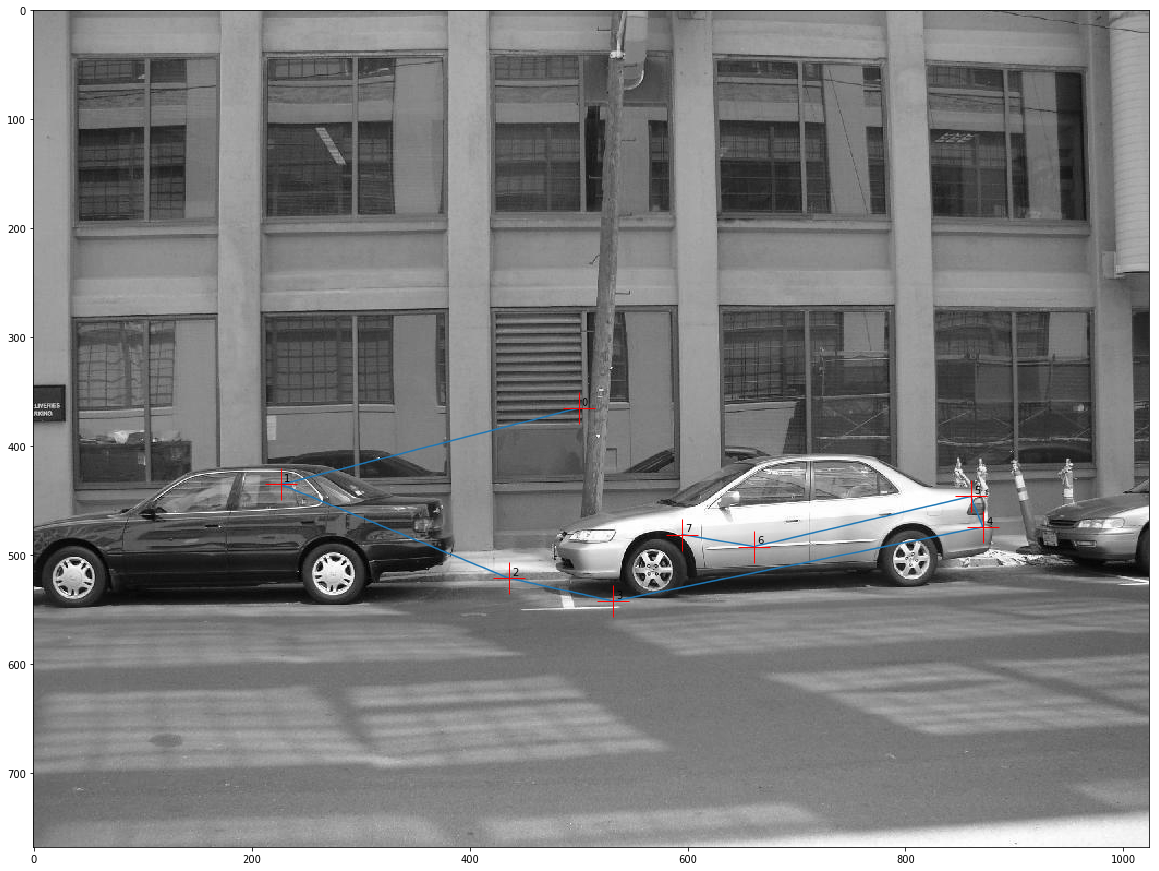

In [5]:
img_orig = np.asarray(img_orig)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
loc_data = np.array(loc_dict['barycenters'])
ax.plot(loc_data[:,0], loc_data[:,1])
for i, coord in enumerate(loc_dict['barycenters']):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

# Testing for two focal points

## A. Reconstructing for each fixation point
### Saccades

In [6]:
loc_data_2=loc_data

In [7]:
img_orig_shape=list(img_orig.shape)
img_orig_shape[0]=img_orig_shape[0]//2
img_orig_shape[1]=img_orig_shape[1]//2

In [8]:
print('image center coordinates =', img_orig_shape)

image center coordinates = [384, 512]


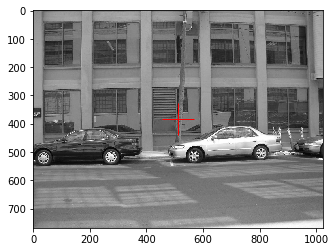

In [9]:
fig, ax = plt.subplots()
ax.imshow(img_orig, cmap='gray')
ax.plot(512, 384, 'r+', ms=32)

In [73]:
img_orig_roll=[]
shift=[]
for i in range(len(loc_data_2)):
    img_orig_cop=img_orig.copy()
    shift.append([img_orig_shape[0]-loc_data_2[i][1], img_orig_shape[1]-loc_data_2[i][0]])
    print('i=', i, 'l initial=', shift[-1][0], 'c initial=', shift[-1][1])
    img_orig_cop=np.roll(img_orig_cop, shift[-1][0], axis=0)
    img_orig_cop=np.roll(img_orig_cop, shift[-1][1], axis=1)
    img_orig_roll.append(torch.Tensor(img_orig_cop[None,None, ...]))

i= 0 l initial= 19 c initial= 12
i= 1 l initial= -51 c initial= 285
i= 2 l initial= -137 c initial= 76
i= 3 l initial= -158 c initial= -20
i= 4 l initial= -90 c initial= -359
i= 5 l initial= -62 c initial= -348
i= 6 l initial= -108 c initial= -149
i= 7 l initial= -97 c initial= -83


### 5. Creating a set of filters

TypeError: Invalid dimensions for image data

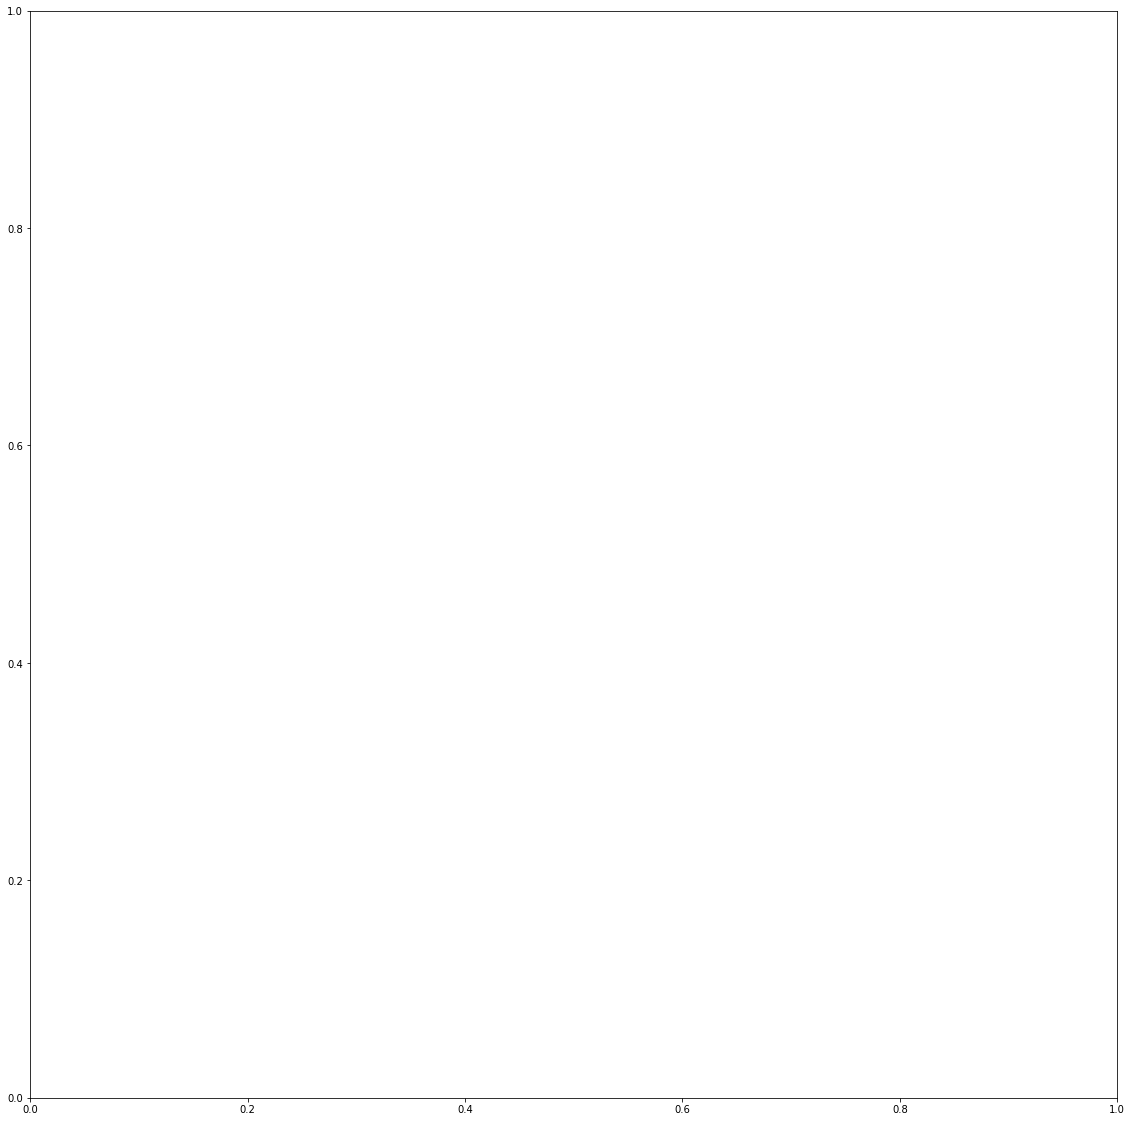

In [76]:
#img_orig_test = np.asarray(img_orig_roll[0])
#fig, ax = plt.subplots(figsize=(20,20)) 
#ax.imshow(img_orig_test, cmap='gray')
#ax.plot(img_orig_shape[1], img_orig_shape[0], 'r+', ms=32)

## Overcomplete retinal pyramid
### 1. Libraries & initialising parameters

In [77]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-04-03T13:21:26+02:00

CPython 3.7.0
IPython 6.5.0

numpy 1.15.1
torch 1.4.0
POLO not installed

compiler   : MSC v.1912 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
host name  : DESKTOP-7F3QJKF
Git hash   : 2da02dbd1fea721c3f5ce16a5cf79ad00f5fd686
Git repo   : https://github.com/bicv/POLO.git
Git branch : master


In [78]:
mode= 'bilinear'
width = 32
r_min = width / 8 #width/16 
r_max = width / 2 #7 * width/16
#base_levels = 1.61803
base_levels = 2
n_sublevel = 4 #cette fois on en met 4
n_azimuth = 12 #var 2->24
n_theta = 12#var 2->24
n_phase = 2

In [84]:
#img_orig_roll=torch.Tensor(img_orig_roll)
#type(img_orig_roll)
len(img_orig_roll)

8

### 2. Image after the ocular saccade 

Tensor shape= torch.Size([1, 1, 768, 1024])


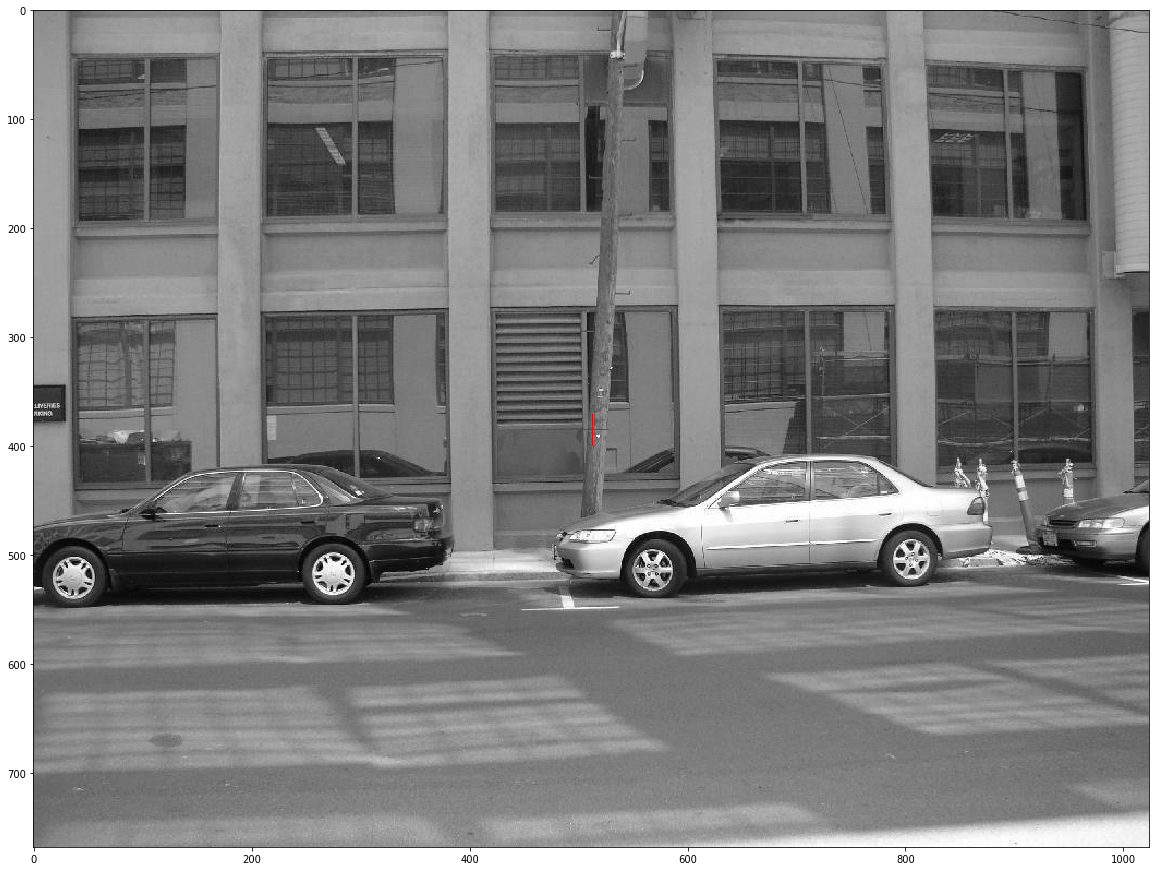

In [14]:
from SLIP import imread
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
N_X, N_Y = img_orig.shape
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': True}


#im = Image(pe)
#img_orig -= img_orig.mean()
#img_orig *= im.mask
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

### 3. using torch to build up a Laplacian pyramid

In [15]:
from torch.nn.functional import interpolate
img_down = img_tens
n_levels = 0
while max(img_down.shape[-2:]) > width :
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


### 4. Cropped pyramid

In [16]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    img_crop = torch.zeros((N_batch, n_levels, width, width))

    img_down = img_tens.clone()
    for i_level in range(n_levels-1):
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:]

        img_crop[:, i_level, :, :] = img_residual[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)]

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    #if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)
    return img_crop

### 6. Inverse pyramid from the coefficients

In [30]:
def inverse_pyramid(out, K_inv, N_X=N_X, N_Y=N_Y, 
                    n_sublevel=n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, n_phase=n_phase,
                    base_levels=base_levels, verbose=False):
    N_batch = out.shape[0]
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    img_crop_rec = out__.reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :]
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

### 7. Retinal transformation function

In [86]:
img_orig_roll_pyr=[]
for i in range(len(img_orig_roll)):
    img_orig_roll_pyr.append(cropped_pyramid(img_orig_roll[i]))

In [87]:
len(img_orig_roll_pyr)

8

In [88]:
sign=[]
for i in range(len(img_orig_roll_pyr)):
    sign.append([])
    if shift[i][0]<0:
        img_orig_roll_pyr[i]=img_orig_roll_pyr[i][:shift[i][0],:]
        sign[-1].append(1) #signe - -> 1, signe + -> 0
    else :
        img_orig_roll_pyr[i]=img_orig_roll_pyr[i][shift[i][0]:,:]
        sign[-1].append(0)
    if shift[i][1]<0:
        img_orig_roll_pyr[i]=img_orig_roll_pyr[i][:,:shift[i][1]]
        sign[-1].append(1)
    else :
        img_orig_roll_pyr[i]=img_orig_roll_pyr[i][:,shift[i][1]:]
        sign[-1].append(0)
        

In [45]:
img_crops[0].shape #comment on fait pour transformer le tout en gros tensor?

torch.Size([1, 6, 32, 32])

In [48]:
img_crop.shape

torch.Size([1, 6, 32, 32])

## Reconstructing the two 

## B. Cropping images

### Creating the new empty image

[[0, 0], [1, 0], [1, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]


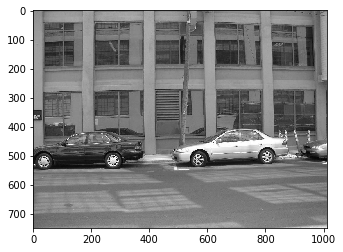

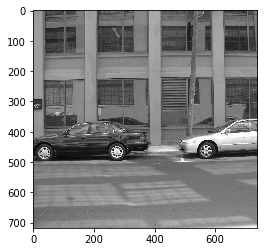

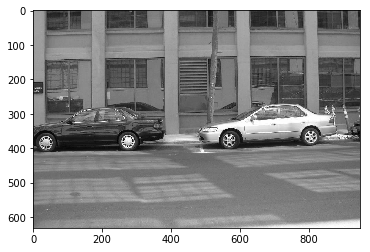

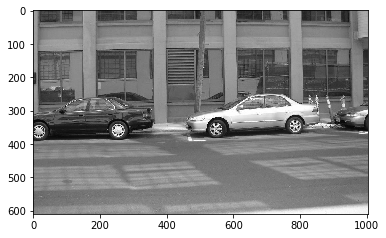

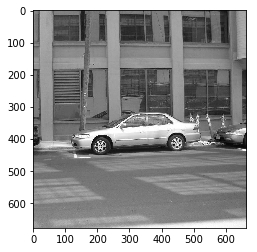

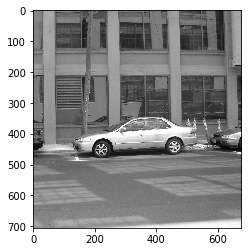

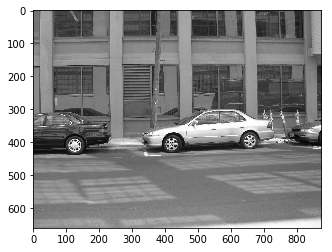

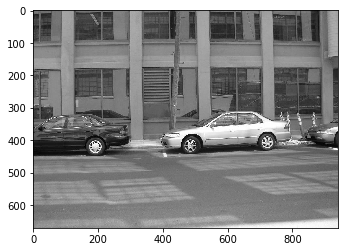

In [24]:
sign=[]
for i in range(len(img_orig_roll_pyr_filt)):
    sign.append([])
    if shift[i][0]<0:
        img_orig_roll[i]=img_orig_roll[i][:shift[i][0],:]
        sign[-1].append(1) #signe - -> 1, signe + -> 0
    else :
        img_orig_roll[i]=img_orig_roll[i][shift[i][0]:,:]
        sign[-1].append(0)
    if shift[i][1]<0:
        img_orig_roll[i]=img_orig_roll[i][:,:shift[i][1]]
        sign[-1].append(1)
    else :
        img_orig_roll[i]=img_orig_roll[i][:,shift[i][1]:]
        sign[-1].append(0)
        
print(sign)        
img_orig_test = np.asarray(img_orig_roll)
for i in range(len(loc_data_2)):
    fig, ax = plt.subplots() 
    ax.imshow(img_orig_test[i], cmap='gray')

In [25]:
img_path=np.zeros([img_orig.shape[0],img_orig.shape[1]])
img_path_zones=np.zeros([img_orig.shape[0],img_orig.shape[1]])
for i in range(len(img_orig_roll_pyr_filt)):
    dimensions=img_orig_roll_pyr_filt[i].shape
    print(dimensions)
    if sign[i]==[0,0]:
        img_path[:dimensions[0], :dimensions[1]]+=img_orig_roll_pyr_filt[i]
        img_path_zones[:dimensions[0], :dimensions[1]]+=1
        
    elif sign[i]==[0,1]:
        img_path[:dimensions[0], img_path.shape[1]-dimensions[1]:]+=img_orig_roll_pyr_filt[i]
        img_path_zones[:dimensions[0], img_path.shape[1]-dimensions[1]:]+=1
        
    elif sign[i]==[1,0]:
        img_path[img_path.shape[0]-dimensions[0]:, :dimensions[1]]+=img_orig_roll_pyr_filt[i]   
        img_path_zones[img_path.shape[0]-dimensions[0]:, :dimensions[1]]+=1
        
    elif sign[i]==[1,1]:
        img_path[img_path.shape[0]-dimensions[0]:, img_path.shape[1]-dimensions[1]:]+=img_orig_roll_pyr_filt[i]  
        img_path_zones[img_path.shape[0]-dimensions[0]:, img_path.shape[1]-dimensions[1]:]+=1
   

          

img_test = np.asarray(img_path)
fig, ax = plt.subplots() 
ax.imshow(img_test, cmap='gray')

for i in range(768):
    for j in range(1024):
        if img_path_zones[i][j]==0:
            img_path_zones[i][j]=1  

(0, 0, 12, 2)


ValueError: operands could not be broadcast together with shapes (0,0) (0,0,12,2) (0,0) 

In [ ]:
K_ = K_azym_thet.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
K_azym_thet_inv = torch.pinverse(K_)
img_rec = inverse_pyramid(img_orig_roll_pyr_filt, K_azym_thet_inv, n_azimuth = n_azimuth, n_theta = n_theta)

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


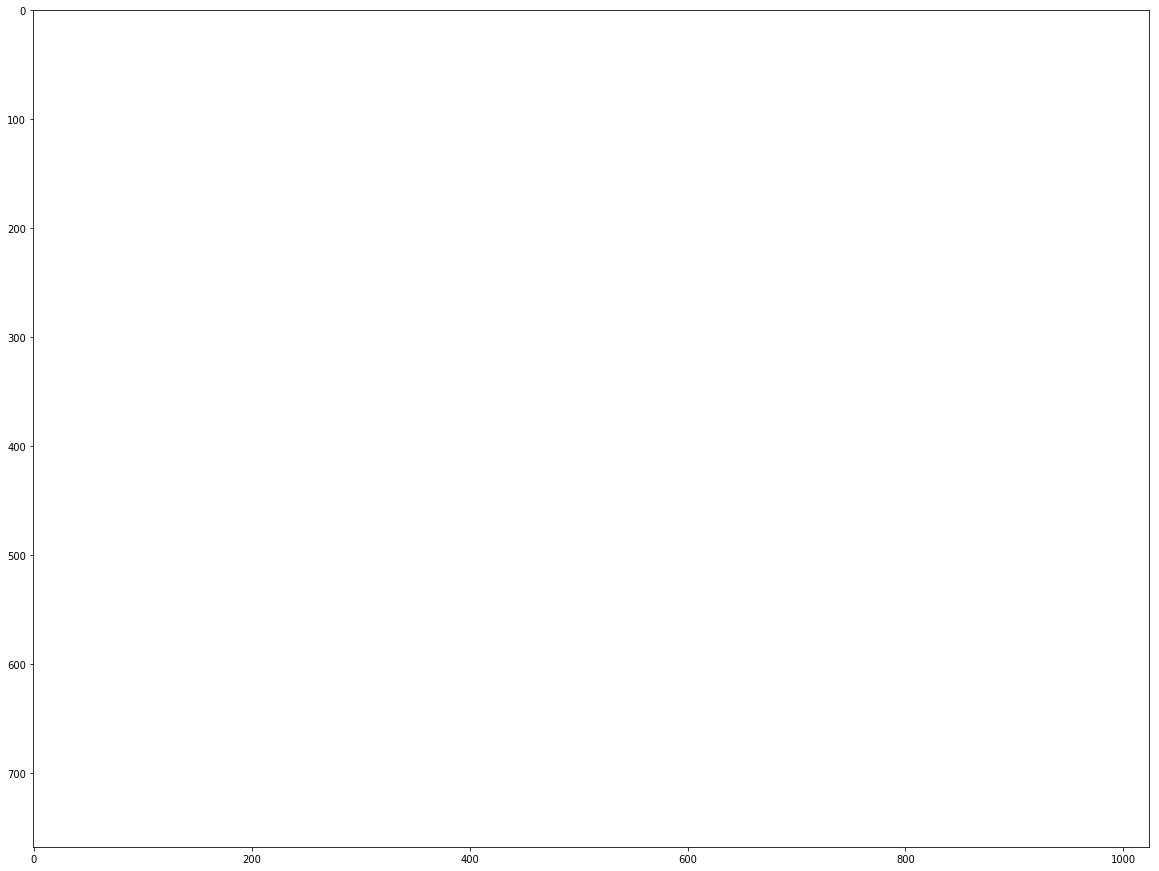

In [26]:
img_final=np.divide(img_path, img_path_zones)   

img_test = np.asarray(img_final)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_test, cmap='gray')


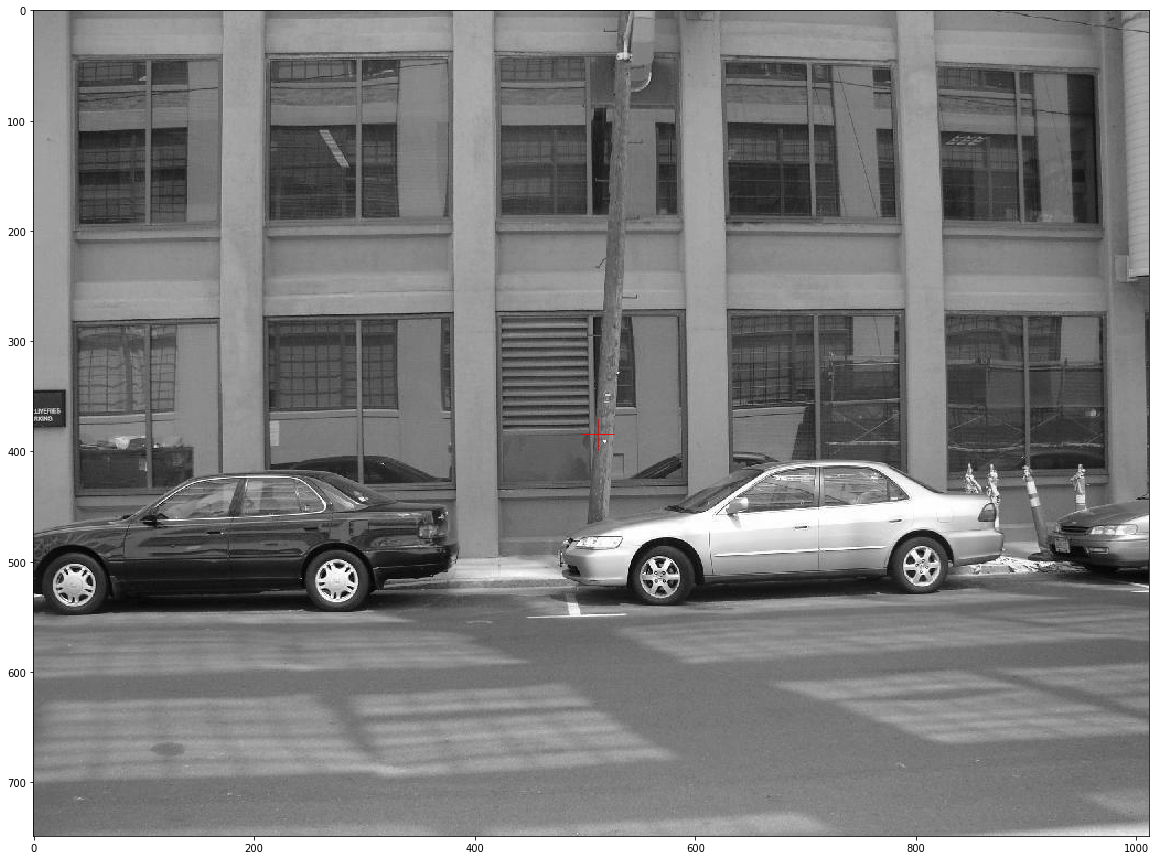

In [27]:
img_orig_test = np.asarray(img_orig_roll[0])
fig, ax = plt.subplots(figsize=(20,20)) 
ax.imshow(img_orig_test, cmap='gray')
ax.plot(img_orig_shape[1], img_orig_shape[0], 'r+', ms=32)